## ENUNCIADO EJERCICIO

* Dataset Airbnb NYC https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data AB_NYC_2019.csv
    * Quitar columnas: id, host_id, host_name
    * Fecha: probar a descomponer la fecha en campos año mes y día con pandas es decir, en 3 columnas, por ejemplo usando to_datetime de pandas y los accesores de fecha para extraer año mes y día.

* EDAs (10%) (menos foco para este módulo)
    * univariantes: histogramas boxplot countplot
    * bivariantes: scatterplot
    * multivariante: corr en heatmap, pairplot
* Preprocesados (20%)
    * numéricas: imputer, scaler, transformer
    * categóricas: imputer, encoder
    * Requisito: hacer los preprocesados con Scikit Learn en lugar de métodos de pandas
* clustering y siluetas (10 %)
    * Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering
    * Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot
* feature selection (10%)
    * SelectKBest para filtrar las mejores columnas y probar
    * PCA 
* Regresión (20%):
    * Predecir la columna 'price'
* Clasificación multiclase (20%)
    * Predecir la columna 'room_type'
* Comparar resultados de modelos con validación cruzada (10 %)
    * Mostrar un dataframe de resultados con las métricas calculadas
    * Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas

* Opcional:
    * Uso de pipelines opcional:
        * Opción 1: hacer las transformaciones por separado manualmente
        * Opción 2: hacer las transformaciones con pipelines
        * Opción 3: una primera parte con transformaciones manuales y una segunda parte con Pipeline
        * En ambos casos sería interesante calcular las métricas para ver qué técnicas de preprocesado van mejor
    * Vectorizar la columna texto 'name' y usar TruncatedSVD
    * Clasificación multiclase 'room_type' con TensorFlow-Keras
    * SMOTE si hay desbalanceo para el problema de clasificación multiclase 'room_type'



In [2]:

import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.svm import SVR

In [3]:
df = pd.read_csv('airbnb_nyc_clean.csv').drop(['id','name','host_id','host_name','last_review', 'house_rules'], axis=1)
df.head(3)

,host_identity_verified,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,142.0,28.0,13.0,45.0,0.38,4.0,2.0,228.0
2,unconfirmed,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,0.79,5.0,1.0,352.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_identity_verified          69305 non-null  object 
 1   neighbourhood_group             69305 non-null  object 
 2   neighbourhood                   69305 non-null  object 
 3   lat                             69305 non-null  float64
 4   long                            69305 non-null  float64
 5   instant_bookable                69305 non-null  bool   
 6   cancellation_policy             69305 non-null  object 
 7   room_type                       69305 non-null  object 
 8   construction_year               69305 non-null  float64
 9   price                           69305 non-null  float64
 10  service_fee                     69305 non-null  float64
 11  minimum_nights                  69305 non-null  float64
 12  number_of_reviews               

In [5]:
df.isna().sum()

host_identity_verified            0
neighbourhood_group               0
neighbourhood                     0
lat                               0
long                              0
instant_bookable                  0
cancellation_policy               0
room_type                         0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [6]:
df.describe()

,lat,long,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
count,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000
mean,40.728070,-73.949036,2012.489503,624.736070,124.894026,4.620330,28.003896,1.301503,3.321636,8.976755,153.184287
std,0.055973,0.050470,5.756144,331.158937,66.222794,4.356887,52.035180,1.659188,1.255746,34.808447,134.421373
min,40.499790,-74.249840,2003.000000,50.000000,10.000000,0.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,40.688540,-73.982790,2008.000000,339.000000,68.000000,2.000000,1.000000,0.300000,2.000000,1.000000,18.000000
50%,40.722650,-73.954390,2012.000000,624.736070,124.894026,3.000000,7.000000,0.790000,3.000000,1.000000,127.000000
75%,40.762730,-73.931380,2017.000000,911.000000,182.000000,6.000000,30.000000,1.730000,4.000000,3.000000,281.000000
max,40.916970,-73.705220,2022.000000,1200.000000,240.000000,13.000000,1024.000000,90.000000,5.000000,332.000000,426.000000


<Axes: ylabel='price'>

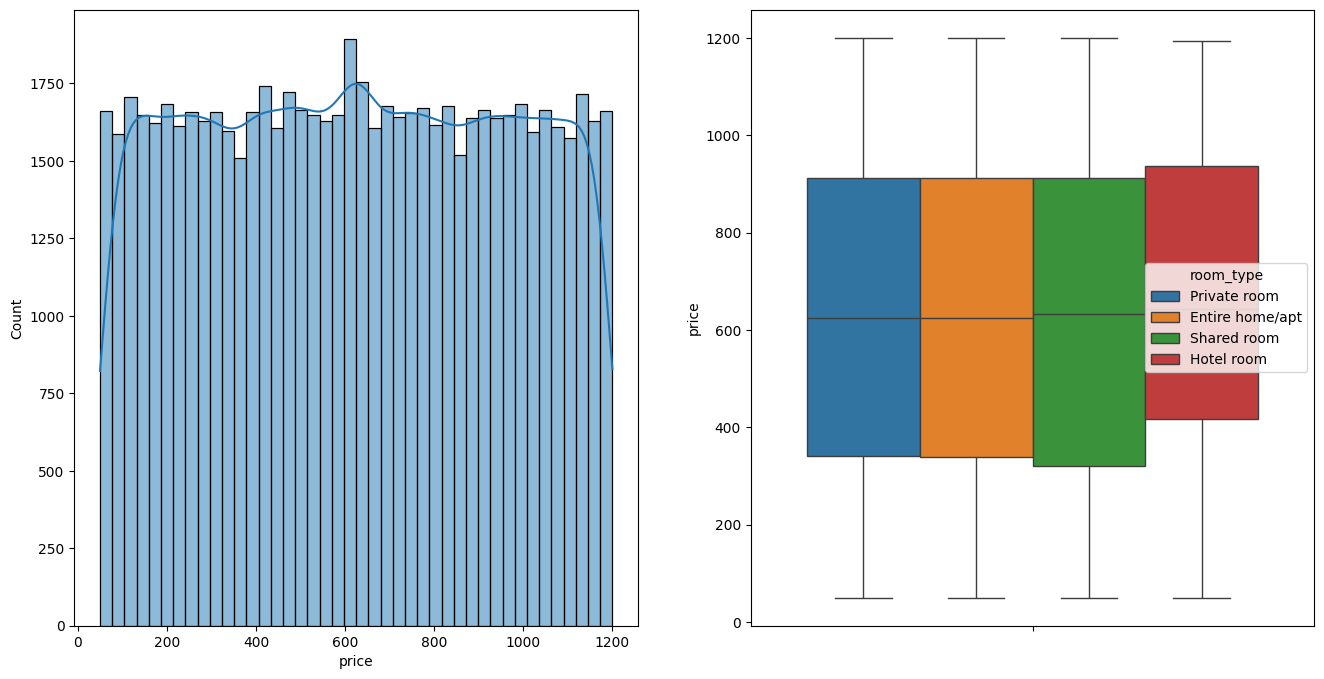

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(df, x='price', kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(df, hue='room_type', y='price')
#sns.countplot(df, x='room_type')

<Axes: >

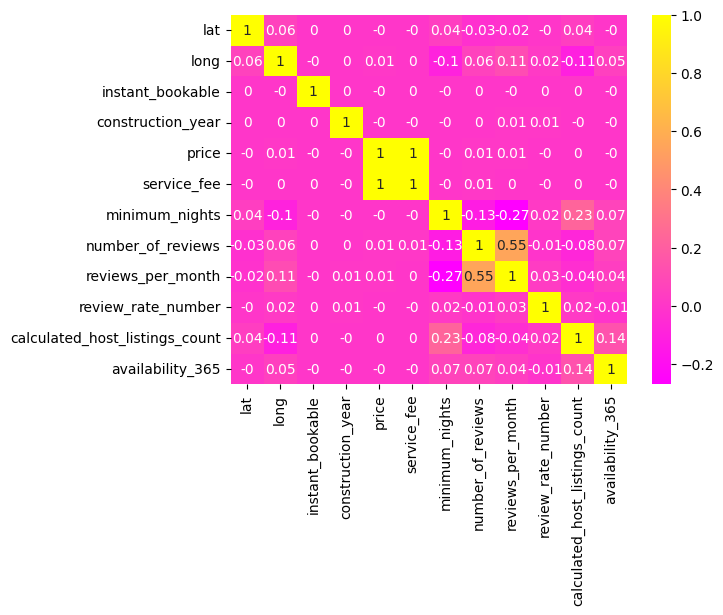

In [12]:
sns.heatmap(df.corr(numeric_only=True).round(2), annot=True, cmap='spring')

In [ ]:
sns.pairplot(df)

In [26]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df['price'] < lower_bound) | (df['price'] > upper_bound))
print(df.shape)
print(df[filtro].shape)


(69305, 17)
(69305, 17)


In [27]:
X= df.drop('price', axis=1)
y= df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
# pipeline numéricas
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.to_list()
pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler()), 
])

# pipeline categóricas
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.to_list()
pipeline_categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Otro')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# unir pipelines con ColumnTransformer
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols),
    ('categorical', pipeline_categorical, categorical_cols)
])

# pipeline final con el modelo
pipeline = make_pipeline(
    pipeline_all,
    LinearRegression()
)

In [29]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [30]:
df_resultados = pd.DataFrame(columns=['Modelo', 'Preprocesado', 'R2', 'MAE', 'RMSE', 'MAPE'])

In [32]:
def calculate_metrics(X_train, X_test, y_train, y_test):
    models = {
        'LinearRegression': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42)
    }
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df_resultados.loc[len(df_resultados)] = [model_name, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred),root_mean_squared_error(y_test, y_pred),mean_absolute_percentage_error(y_test, y_pred)]
    
    return df_resultados.sort_values('R2', ascending=False)

In [34]:
calculate_metrics(X_train[numerical_cols], X_test, y_train, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cancellation_policy
- host_identity_verified
- instant_bookable
- neighbourhood
- neighbourhood_group
- ...
